<a href="https://colab.research.google.com/github/GitSanyaHub/NLP/blob/main/LLaMA/LLaMA_version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# PyTorch for implementing LLM (No GPU)
import torch

# Neural network modules and functions from PyTorch
from torch import nn
from torch.nn import functional as F

# NumPy for numerical operations
import numpy as np

# Matplotlib for plotting Loss etc.
from matplotlib import pyplot as plt

# Time module for tracking execution time
import time

# Pandas for data manipulation and analysis
import pandas as pd

# urllib for handling URL requests (Downloading Dataset)
import urllib.request

# отслеживание выполнения
from tqdm import tqdm

from collections import OrderedDict


In [ ]:
# Configuration object for model parameters
MASTER_CONFIG = {
    'batch_size': 32,        # Number of batches to be processed at each random split
    'context_window': 16,    # Number of characters in each input (x) and target (y) sequence of each batch
    'd_model': 128,          # Dimension of linear layers (128)
    'vocab_size': 65,
    'epochs': 3000,          # Number of training epochs
    'log_interval': 10,      # Log information every 10 batches during training
    'n_heads': 8,            # Number of attention heads
    'n_layers': 4,            # Set the number of layers to 4
}


In [ ]:
# The URL of the raw text file on GitHub
url = "https://raw.githubusercontent.com/bkitano/llama-from-scratch/main/input.txt"

# The file name for local storage
file_name = "tinyshakespeare.txt"

# Execute the download
urllib.request.urlretrieve(url, file_name)


('tinyshakespeare.txt', <http.client.HTTPMessage at 0x7d2f75c83d00>)

In [ ]:
# Read the content of the dataset
lines = open("tinyshakespeare.txt", 'r').read()

print(lines[:1000])

# Create a sorted list of unique characters in the dataset
vocab = sorted(list(set(lines)))

# Display the first 10 characters in the vocabulary list
print('Printing the first 10 characters of the vocab list:', vocab[:10])

# Output the total number of characters in our dataset (Vocabulary Size)
print('Total number of characters in our dataset (Vocabulary Size):', len(vocab))

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [ ]:
# Output of above code
# Mapping integers to characters (itos)
itos = {i: ch for i, ch in enumerate(vocab)}

# Mapping characters to integers (stoi)
stoi = {ch: i for i, ch in enumerate(vocab)}
# Encode function: Converts a string to a list of integers using the mapping stoi
def encode(s):
    return [stoi[ch] for ch in s]

# Decode function: Converts a list of integers back to a string using the mapping itos
def decode(l):
    return ''.join([itos[i] for i in l])

# Example: Encode the string "hello" and then decode the result
decode(encode("morning"))

'morning'

In [ ]:
# Convert the dataset into a torch tensor with specified data type (dtype)
dataset = torch.tensor(encode(lines), dtype=torch.int8)

# Display the shape of the resulting tensor
print(dataset.shape)

torch.Size([1115394])


# Тут все функции

In [ ]:
# Определяем устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Function to get batches for training, validation, or testing
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    # Split the dataset into training, validation, and test sets
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    # Determine which split to use
    batch_data = train
    if split == 'val':
        batch_data = val
    if split == 'test':
        batch_data = test

    # Pick random starting points within the data
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))

    # Create input sequences (x) and corresponding target sequences (y)
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long().to(device)
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long().to(device)

    return x, y


@torch.no_grad()  # Don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    # Placeholder for the evaluation results
    out = {}

    # Set the model to evaluation mode
    model.eval()

    # Iterate through training and validation splits
    for split in ["train", "val"]:
        # Placeholder for individual losses
        losses = []

        # Generate 10 batches for evaluation
        for _ in range(10):
            # Get input sequences (xb) and target sequences (yb)
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])

            # Perform model inference and calculate the loss
            _, loss = model(xb, yb)

            # Append the loss to the list
            losses.append(loss.item())

        # Calculate the mean loss for the split and store it in the output dictionary
        out[split] = np.mean(losses)

    # Set the model back to training mode
    model.train()

    return out


# Function to perform training
def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    # Placeholder for storing losses
    losses = []

    # Start tracking time
    start_time = time.time()

    # Переместим модель на устройство
    model.to(device)

    # Iterate through epochs
    for epoch in tqdm(range(config['epochs']), desc="Training"):
        # Zero out gradients
        optimizer.zero_grad()

        # Obtain batches for training
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

        # Forward pass through the model to calculate logits and loss
        logits, loss = model(xs, targets=ys)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # If a learning rate scheduler is provided, adjust the learning rate
        if scheduler:
            scheduler.step()

        # Log progress every specified interval
        if epoch % config['log_interval'] == 0:
            # Calculate batch time
            batch_time = time.time() - start_time

            # Evaluate loss on validation set
            x = evaluate_loss(model)

            # Store the validation loss
            losses += [x]

            # Print progress logs if specified
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")

            # Reset the timer
            start_time = time.time()

            # Print learning rate if a scheduler is provided
            if scheduler:
                print("lr: ", scheduler.get_lr())

    # Print the final validation loss
    print("Validation loss: ", losses[-1]['val'])

    # Plot the training and validation loss curves
    return pd.DataFrame(losses).plot()

class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()

        # Registering a learnable parameter 'scale' as a parameter of the module
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        """
        Assumes shape is (batch, seq_len, d_model)
        """
        # Calculating the Frobenius norm, RMS = 1/sqrt(N) * Frobenius norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5

        # Normalizing the input tensor 'x' with respect to RMS
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)

        # Scaling the normalized tensor using the learnable parameter 'scale'
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

def get_rotary_matrix(context_window, embedding_dim):
    # Initialize a tensor for the rotary matrix with zeros
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)

    # Loop through each position in the context window
    for position in range(context_window):
        # Loop through each dimension in the embedding
        for i in range(embedding_dim // 2):
            # Calculate the rotation angle (theta) based on the position and embedding dimension
            theta = 10000. ** (-2. * (i - 1) / embedding_dim)
            # Calculate the rotated matrix elements using sine and cosine functions
            m_theta = position * theta
            R[position, 2 * i, 2 * i] = np.cos(m_theta)
            R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
    return R

class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Linear transformation for query
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Linear transformation for key
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Linear transformation for value
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Obtain rotary matrix for positional embeddings
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        # Generate rotational matrix for RoPE
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                # Calculate the rotation angle (theta) based on the position and embedding dimension
                theta = 10000. ** (-2. * (i - 1) / embedding_dim)
                # Calculate the rotated matrix elements using sine and cosine functions
                m_theta = position * theta
                R[position, 2 * i, 2 * i] = np.cos(m_theta)
                R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        # x: input tensor of shape (batch, sequence length, dimension)
        x.to(device)
        b, m, d = x.shape  # batch size, sequence length, dimension

        # Linear transformations for Q, K, and V
        q = self.w_q(x).to(device)
        k = self.w_k(x).to(device)
        v = self.w_v(x).to(device)
        R = self.R.to(device)

        # Rotate Q and K using the RoPE matrix
        q_rotated = (torch.bmm(q.transpose(0, 1), R[:m])).transpose(0, 1)
        k_rotated = (torch.bmm(k.transpose(0, 1), R[:m])).transpose(0, 1)

        # Perform scaled dot-product attention
        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True
        )

        if return_attn_weights:
            # Create a causal attention mask
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0)
            # Calculate attention weights and add causal mask
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights

        return activations

class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Create a list of RoPEMaskedAttentionHead instances as attention heads
        self.heads = nn.ModuleList([
            RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])  # Linear layer after concatenating heads
        self.dropout = nn.Dropout(.1)  # Dropout layer

    def forward(self, x):
        # x: input tensor of shape (batch, sequence length, dimension)
        x.to(device)

        # Process each attention head and concatenate the results
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)

        # Apply linear transformation to the concatenated output
        x = self.linear(x)

        # Apply dropout
        x = self.dropout(x)
        return x

class SwiGLU(nn.Module):
    """ Paper Link -> https://arxiv.org/pdf/2002.05202v1.pdf """
    def __init__(self, size):
        super().__init__()
        self.linear_gate = nn.Linear(size, size)  # Linear transformation for the gating mechanism
        self.linear = nn.Linear(size, size)  # Linear transformation for the main branch
        self.beta = torch.randn(1, requires_grad=True)  # Random initialization of the beta parameter

        # Using nn.Parameter for beta to ensure it's recognized as a learnable parameter
        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        # Swish-Gated Linear Unit computation
        x.to(device)
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)  # Element-wise multiplication of the gate and main branch
        return out


# add RMSNorm and residual connection
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # RMSNorm layer
        self.rms = RMSNorm((config['context_window'], config['d_model']))

        # RoPE Masked Multihead Attention layer
        self.attention = RoPEMaskedMultiheadAttention(config)

        # Feedforward layer with SwiGLU activation
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        # one block of attention
        x = self.rms(x) # RMS pre-normalization
        x = x + self.attention(x)  # residual connection

        x = self.rms(x) # RMS pre-normalization
        x = x + self.feedforward(x)  # residual connection
        return x



class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Embedding layer for token representations
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        # Sequential block of LlamaBlocks based on the specified number of layers
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )
        # Feedforward network (FFN) for final output
        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # Print total number of parameters in the model
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        # Input token indices are passed through the embedding layer
        x = self.embeddings(idx)
        # Process the input through the LlamaBlocks
        x = self.llama_blocks(x)
        # Pass the processed input through the final FFN for output logits
        logits = self.ffn(x)

        # If targets are not provided, return only the logits
        if targets is None:
            return logits
        # If targets are provided, compute and return the cross-entropy loss
        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

# Запуск модели

model params: 2370246
Total number of parameters in the Model: 2370246


Training: 100%|██████████| 3000/3000 [07:02<00:00,  7.10it/s]

Validation loss:  1.7440804362297058


<Axes: >

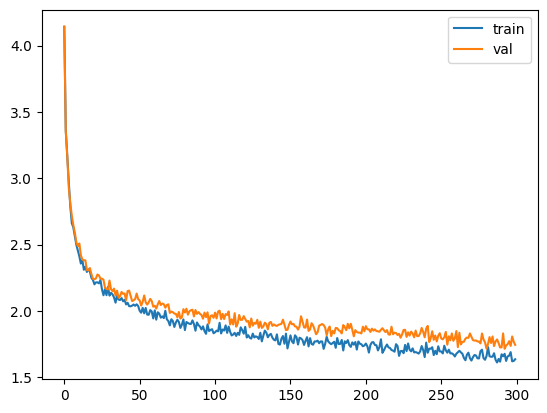

In [ ]:
# Перемещаем модель на устройство
llama = Llama(MASTER_CONFIG).to(device)

# Перемещаем батчи данных на устройство
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
xs, ys = xs.to(device), ys.to(device)

# Количество параметров модели
print("Total number of parameters in the Model:", sum([m.numel() for m in llama.parameters()]))

# Определяем Adam оптимизатор для параметров модели
optimizer = torch.optim.Adam(llama.parameters())

# Выполняем процесс обучения
train(llama, optimizer)

In [ ]:
device = torch.device("cpu")

# Generate function for text generation using the trained model
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    model.to(device)
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # Call the model
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [decode(x) for x in idx.tolist()]


# Generate text using the trained LLM (llama) with a maximum of 500 tokens
generated_text = generate(llama, MASTER_CONFIG, 500)[0]
print(generated_text)



His navy writh me
He is! For ore, prisoin
in of those of thither: the with me ow, sir,
You', and depert oft vablosling,
Mase mays bom manbal.

GRPALIP:
And sin chance IV:
Sweet foic con:
Fwith nain 'tser 'tis,
To troublt of they, end:
By tro evers sonour. So proud it sI hosps,
Here's priddampace;
As peneans: in yous rayce, grosal pign''d frost;
Phost have hists honhul II thill in gurt thh spostsk'd'swidear;
Chnmand: theres I mille
'And vyord but I din than e'er;
They soplain him?

MOLKINGE:
O WA
